In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import re
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
import psycopg2
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from classify_campaigns import classify_campaigns

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [100]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()

In [101]:
start_dt = '2021-09-10'
end_dt = '2021-09-11'


Can we identify installs by time after the App Download event? 

What percent of those are already attributed to us?

In [34]:
opens_downloads_query = f"""
select 
    IgniteID
    , i.imei as imei_install
    , o.imei as imei_open
    , install_date
    , open_date
FROM (
    select p.uid || '_' || t.transactionid AS IgniteID, p.imei, createdate as install_date
    from rawdata.dt_transactions t
    join rawdata.dt_transactions_events te on te.TransactionId = t.TransactionId AND te.rs_carrier_id = t.rs_carrier_id
    join rawdata.dt_events e on e.eventId=te.eventId and e.rs_carrier_id = te.rs_carrier_id
    join rawdata.dt_process p on t.processid = p.ProcessId and p.rs_carrier_id = t.rs_carrier_id
    join rawdata.dt_carrier_apps ca on ca.carrierappid = t.carrierappid and ca.rs_carrier_id = p.rs_carrier_id
    join rawdata.dt_app a on a.appid = ca.appid and a.rs_carrier_id = ca.rs_carrier_id
    where e.code = 490
    and a.packagename = 'com.zhiliaoapp.musically'
    and date(te.eventdate) >= date('{start_dt}') - 30
    and date(te.eventdate) <= date('{end_dt}')
    and right(imei,1) = '0'
) i
FULL OUTER JOIN (
    select p.imei, createdate as open_date
    from rawdata.dt_transactions t
    join rawdata.dt_transactions_events te on te.TransactionId = t.TransactionId AND te.rs_carrier_id = t.rs_carrier_id
    join rawdata.dt_events e on e.eventId=te.eventId and e.rs_carrier_id = te.rs_carrier_id
    join rawdata.dt_process p on t.processid = p.ProcessId and p.rs_carrier_id = t.rs_carrier_id
    join rawdata.dt_carrier_apps ca on ca.carrierappid = t.carrierappid and ca.rs_carrier_id = p.rs_carrier_id
    join rawdata.dt_app a on a.appid = ca.appid and a.rs_carrier_id = ca.rs_carrier_id
    where e.code = 612
    and a.packagename = 'com.zhiliaoapp.musically'
    and date(te.eventdate) >= date('{start_dt}')
    and date(te.eventdate) <= date('{end_dt}')
    and right(imei,1) = '0'
) o
    ON i.imei = o.imei
    and o.open_date >= i.install_date
"""
cur_atlas.execute(opens_downloads_query)
df_downloads_opens = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

In [83]:
print(df_downloads_opens[['imei_install','imei_open']].count())
print(df_downloads_opens[['imei_install','imei_open']].nunique())

imei_install    556470
imei_open        47106
dtype: int64
imei_install    474361
imei_open        13943
dtype: int64


In [36]:
df_downloads_opens.loc[~df_downloads_opens.imei_open.isna(), ['open_date','install_date']].count()

open_date       47106
install_date    45316
dtype: int64

In [84]:
df_downloads_opens.groupby('imei_install')['install_date','open_date'].nunique().value_counts(normalize = True).head(10)

install_date  open_date
1             0            0.929079
2             0            0.034980
1             1            0.024401
3             0            0.006164
4             0            0.001830
2             1            0.001143
5             0            0.000750
6             0            0.000392
3             1            0.000183
7             0            0.000181
dtype: float64

In [54]:
df_downloads_opens['TTO'] = (df_downloads_opens.open_date - df_downloads_opens.install_date).dt.seconds

df_downloads_opens['TTO'].value_counts(normalize = True).sort_index().head(20)

0.0      0.950989
23.0     0.000375
25.0     0.000044
65.0     0.000044
77.0     0.000044
97.0     0.000022
109.0    0.000022
186.0    0.000022
199.0    0.000022
201.0    0.000022
205.0    0.000022
250.0    0.000177
254.0    0.000022
283.0    0.000022
305.0    0.000022
448.0    0.000022
451.0    0.000022
487.0    0.000022
495.0    0.000022
538.0    0.000022
Name: TTO, dtype: float64

(-0.1, 1.0)

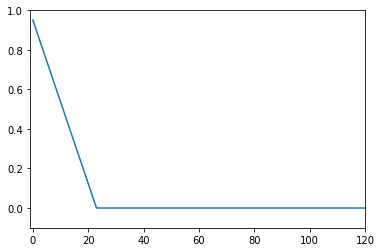

In [76]:
fig, ax = plt.subplots(1,1)
df_downloads_opens['TTO'].value_counts(normalize = True).sort_index().plot()
ax.set_xlim(-1,120)
ax.set_ylim(-.1,1)

In [53]:
installs_query = f"""
select 
    advertising_id
    , i.imei
    , tracking_time
from rawdata.campaign_tracking_active_install cti 
left join 
(
    select p.uid || '_' || t.transactionid AS IgniteID, p.imei, createdate as open_date
    from rawdata.dt_transactions t
    join rawdata.dt_transactions_events te on te.TransactionId = t.TransactionId AND te.rs_carrier_id = t.rs_carrier_id
    join rawdata.dt_events e on e.eventId=te.eventId and e.rs_carrier_id = te.rs_carrier_id
    join rawdata.dt_process p on t.processid = p.ProcessId and p.rs_carrier_id = t.rs_carrier_id
    join rawdata.dt_carrier_apps ca on ca.carrierappid = t.carrierappid and ca.rs_carrier_id = p.rs_carrier_id
    join rawdata.dt_app a on a.appid = ca.appid and a.rs_carrier_id = ca.rs_carrier_id
    where e.code = 612
    and a.packagename = 'com.zhiliaoapp.musically'
    and date(te.eventdate) >= date('{start_dt}') 
    and date(te.eventdate) <= date('{end_dt}')
    and right(imei,1) = '0'
) i
    on i.IgniteID = cti.reqid
where 
    android_package_name = 'com.zhiliaoapp.musically'
    and date(tracking_time) >= date('{start_dt}')
    and date(tracking_time) <= date('{end_dt}')
"""
cur_atlas.execute(installs_query)
df_installs = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

In [80]:
df_installs#.advertising_id.nunique()

advertising_id  \
0       e24dc8b5-d8d7-4f0a-af67-b2cfbec11a97   
1       f453b568-84e3-4d79-8855-b0e7327e9622   
2       05ef4a1b-6502-4633-b200-2b69300fb6d6   
3       5a63a589-d9a4-4799-a5e6-314e5ba27a1e   
4       240510a9-840f-4c76-a0e8-531fa8f43504   
...                                      ...   
162674  d53959a2-8cde-4a32-bd9e-b0f509c4f772   
162675  202f9247-18e8-4ac3-840a-9852c2987c43   
162676  5114faf8-d86d-4c33-ac47-a9aa0eba010d   
162677  93b61a6b-368d-4c4d-9698-2cd42d3778f5   
162678  51bf589c-aa81-4426-92c4-f38db2b59933   

                                                 imei       tracking_time  
0                16a0f1ba-e701-4344-bdac-8825ba251ac0 2021-09-10 14:17:42  
1                47835cae-ee74-4a2d-bd91-f6ab8d00b2a0 2021-09-10 22:38:11  
2       6f8939251b63b36517fd00c967fe26bb731fa6a7b2930 2021-09-10 17:37:54  
3                7e2b8ee5-7f70-4c1c-b9b4-28bd81bf8e50 2021-09-10 13:46:17  
4       d09cefac3f3778386d4242d147fd0a0f443e7d82b3e50 2021-09-10 19:03:01  
...                                               ...                 ...  
162674                                           None 2021-09-11 11:13:30  
162675                                           None 2021-09-11 11:17:05  
162676                                           None 2021-09-11 12:43:53  
162677                                           None 2021-09-11 16:01:37  
162678                                           None 2021-09-11 19:45:06  

[162679 rows x 3 columns]

In [81]:
df_installs.advertising_id.nunique()

162611

In [104]:
preloads_query = f"""
    select
        aaid
        , preload_type
        , t.site_name
        , t.site_id
        , tracking_time as timestamp_preload
        , case when device_app_preloads > 0 then 'test' else 'control' end as test_audience
    from
    (
        select 
            ctp.advertising_id as aaid 
            , tracking_time
            , case when android_package_name = 'com.zhiliaoapp.musically' then 1 else 0 end as is_app_preload
            , ctp.site_id
            , max(s.site_name) as site_name
            , case when site_name like '%AppSelect%' then 'AppSelect' else 'Silent' end as preload_type
            , sum(count(case when android_package_name = 'com.zhiliaoapp.musically' then 1 else NULl end)) 
                over (partition by ctp.advertising_id) as device_app_preloads
        from rawdata.campaign_tracking_active_preload ctp 
        join (
            select
                date(tracking_time) as preload_dt
                , site_id
            from rawdata.campaign_tracking_active_preload
                where android_package_name = 'com.zhiliaoapp.musically'    
                and date(tracking_time) >= date('{start_dt}')
                and date(tracking_time) <= date('{end_dt}')
            group by 1,2
        ) app
            on ctp.site_id = app.site_id
            and date(ctp.tracking_time) = app.preload_dt
        join 
        (
            select p.uid || '_' || t.transactionid AS IgniteID, p.imei, createdate as open_date
            from rawdata.dt_transactions t
            join rawdata.dt_transactions_events te on te.TransactionId = t.TransactionId AND te.rs_carrier_id = t.rs_carrier_id
            join rawdata.dt_events e on e.eventId=te.eventId and e.rs_carrier_id = te.rs_carrier_id
            join rawdata.dt_process p on t.processid = p.ProcessId and p.rs_carrier_id = t.rs_carrier_id
            join rawdata.dt_carrier_apps ca on ca.carrierappid = t.carrierappid and ca.rs_carrier_id = p.rs_carrier_id
            join rawdata.dt_app a on a.appid = ca.appid and a.rs_carrier_id = ca.rs_carrier_id
            where e.code = 490
            and date(te.eventdate) >= date('{start_dt}') 
            and date(te.eventdate) <= date('{end_dt}')
            and right(imei,1) = '0'
        ) i
            on i.IgniteID = ctp.reqid
        join rawdata.site s 
            on ctp.site_id = s.site_id
        where 
            date(tracking_time) >= date('{start_dt}')
            and date(tracking_time) <= date('{end_dt}')
        group by 1,2,3,4,6
    ) t
    where
        (device_app_preloads > 0 and is_app_preload = 1) --is test device, and is a test app preload
        or (device_app_preloads = 0 and is_app_preload = 0) --is control device, and is non-test-app preload
    group by 1,2,3,4,5,6
"""
cur_atlas.execute(preloads_query)
df_preloads = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

In [105]:
df_preloads

aaid preload_type  \
0       0015337c-92e3-44f8-ad8f-bd2d17f3115a       Silent   
1       0015337c-92e3-44f8-ad8f-bd2d17f3115a       Silent   
2       0015337c-92e3-44f8-ad8f-bd2d17f3115a       Silent   
3       0015337c-92e3-44f8-ad8f-bd2d17f3115a       Silent   
4       0015337c-92e3-44f8-ad8f-bd2d17f3115a       Silent   
...                                      ...          ...   
139543  ffd60f11-24ea-4157-b45c-08de4f7dd8f5       Silent   
139544  fff0bb7f-6763-40db-b3d0-c2daf0583aba       Silent   
139545  fff0bb7f-6763-40db-b3d0-c2daf0583aba       Silent   
139546  fff0bb7f-6763-40db-b3d0-c2daf0583aba       Silent   
139547  fff0bb7f-6763-40db-b3d0-c2daf0583aba       Silent   

                                             site_name  site_id  \
0       DT - DTOM - ATT - Multi - Ignite - All Devices    10492   
1       DT - DTOM - ATT - Multi - Ignite - All Devices    10492   
2       DT - DTOM - ATT - Multi - Ignite - All Devices    10492   
3       DT - DTOM - ATT - Multi - Ignite - All Devices    10492   
4       DT - DTOM - ATT - Multi - Ignite - All Devices    10492   
...                                                ...      ...   
139543            DT - Tracfone - Ignite - LG - L322DL    11656   
139544   DT - AMX - MX - Ignite - Exceptions - Devices    10242   
139545   DT - AMX - MX - Ignite - Exceptions - Devices    10242   
139546   DT - AMX - MX - Ignite - Exceptions - Devices    10242   
139547   DT - AMX - MX - Ignite - Exceptions - Devices    10242   

         timestamp_preload test_audience  
0      2021-09-10 19:43:13       control  
1      2021-09-10 20:06:14       control  
2      2021-09-10 19:57:53       control  
3      2021-09-10 20:15:41       control  
4      2021-09-10 20:03:15       control  
...                    ...           ...  
139543 2021-09-10 21:13:28       control  
139544 2021-09-10 12:17:43       control  
139545 2021-09-10 12:32:29       control  
139546 2021-09-10 12:21:34       control  
139547 2021-09-10 12:33:35       control  

[139548 rows x 6 columns]